In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline


In [3]:
lineage_order = ["driver::send", 
                     "clipper::frontend_rpc_recv", 
                     "clipper::task_enqueued", 
                     "clipper::task_dequeued", 
                     "clipper::sent_rpc", 
                     "container::recv",
                     "container::send", 
                     "clipper::rpc_recv", 
                     "clipper::task_executor_recv",
                     "clipper::task_executor_recv_end",
                     "clipper::task_executor_msg_callback_found",
                     "clipper::zmq_frontend_response_callback", 
                     "clipper::frontend_rpc_response_send", 
                     "driver::recv"]

points_to_include = [
#     "driver::send",                  
    "clipper::frontend_rpc_recv", 
    "clipper::task_enqueued",
    "clipper::task_dequeued",
    "clipper::sent_rpc",
    "container::recv",
    "container::send",
    "clipper::rpc_recv",
    "clipper::task_executor_recv",
    "clipper::task_executor_msg_callback_found",
    "clipper::task_executor_recv_end",
    "clipper::zmq_frontend_response_callback",
    "clipper::frontend_rpc_response_send",
    "driver::recv"
]

# def extract_lineage(lineage):
#     first_key = "driver::send"
# #     first_key = "clipper::frontend_rpc_recv"
# #     first_key = "clipper::task_dequeued"
# #     first_key = "container::send"

#     keys = lineage[0].keys()
#     extracted = {k: [] for k in lineage[0].keys()}
#     for entry in lineage:
#         start_timestamp = entry[first_key]
#         for k, v in entry.items():
#             if k != first_key and v > start_timestamp:
#                 extracted[k].append(float(v - start_timestamp) / 1000.0)
#     return extracted

def extract_lineage_deltas(lineage):
    first_key = "driver::send"
#     first_key = "clipper::frontend_rpc_recv"
#     first_key = "clipper::task_dequeued"
#     first_key = "container::send"

    extracted = {k: [] for k in lineage_order}
    for entry in lineage:
        for i in range(1,len(lineage_order)):
            try:
                k = lineage_order[i]
            
                previous_timestamp = entry[lineage_order[i-1]]
            
                delta = entry[k] - previous_timestamp
                extracted[k].append(float(delta) / 1000.0)
            except KeyError as e:
                print("CCCCCCCCCCCCCCCCCCC")
    return extracted



def analyze_lineage(path):
    with open(path, "r") as f:
        try:
            results = json.load(f)
        except e:
            print(e)
    try:
        lineages = {m: extract_lineage_deltas(l) for m, l in results["throughput_results"]["lineage"].items()}
#         extracted_lineage = extract_lineage_deltas(results["throughput_results"]["lineage"])
        for m, extracted_lineage in lineages.items():
            display(Markdown("# Model: {m}".format(m=m)))
            for k in lineage_order:
                v = extracted_lineage[k]
                if len(v) > 0:
                    if k in points_to_include:
                        fig, (ax_scatter, ax_hist) = plt.subplots(ncols=2, figsize=(20,6))
                        ax_scatter.scatter(np.arange(len(v)), v, alpha = 0.4, label=k)
                        ax_scatter.legend(loc=0)
                        ax_scatter.set_ylabel("Time (ms)")
            #             ax_hist.hist(v, 50, label=k, normed=1, histtype='step', cumulative=False,)
                        ax_hist.hist(v, 100, label=k, normed=True, histtype='bar', cumulative=False, log=True)
                        xmax = ax_hist.get_xlim()[1]
                        ax_hist.set_xlim(right=max(10, xmax))
                        ax_hist.set_xlabel("Time (ms)")
                        ax_hist.set_ylabel("Query ID")
                        ax_hist.set_ylabel("Count (normalized)")
                        ax_hist.grid(b=True, which="both")
                        fig.suptitle(k, fontsize=20)
                        plt.show()
    except KeyError as e:
        print("DDDDDDDDDDDDDDDDDDDD")
                
def compare_lineages(path, batch_size_fixed):
    fs = list(os.listdir(path))
    fs_dict = {}
    for f in fs:
        if f[-4:] == "json":
            splits = f.split("-")
            batch = int(splits[9])
            input_size = int(splits[11])
            if batch == batch_size_fixed:
                fs_dict[(batch, input_size)] = f
    sorted_fs = OrderedDict((k, fs_dict[k]) for k in sorted(list(fs_dict.keys())))
    figs = {}
    for point in points_to_include:
        figs[point] = plt.subplots(ncols=2, figsize=(20,6))
    for (batch, input_size), f in sorted_fs.items():
        try:
            fpath = os.path.join(path, f)
            with open(fpath, "r") as f:
                results = json.load(f)
            extracted_lineage = extract_lineage_deltas(results["steady_results"]["lineage"])
            for k in lineage_order:
                v = extracted_lineage[k]
                if len(v) > 0:
                    if k in points_to_include:
                        fig, (ax_scatter, ax_hist) = figs[k]
                        ax_scatter.scatter(np.arange(len(v)), v, alpha = 0.3, label=str(input_size))
                        ax_hist.hist(v, 100, label=str(input_size), normed=True, histtype='bar', cumulative=False, log=True, alpha=0.7)
                        
        except KeyError as k:
            print(k)
    for point in figs:
        fig, (ax_scatter, ax_hist) = figs[point]
        ax_scatter.legend(loc=0)
        ax_scatter.set_ylabel("Time (ms)")
        xmax = ax_hist.get_xlim()[1]
        ax_hist.set_xlim(right=max(10, xmax))
        ax_hist.set_xlabel("Time (ms)")
        ax_hist.set_ylabel("Query ID")
        ax_hist.set_ylabel("Count (normalized)")
        ax_hist.legend(loc=0)
        ax_hist.grid(b=True, which="both")
        fig.suptitle(point, fontsize=20)
        display(Markdown("# Input Size: {i}, Batch size: {b}".format(i=input_size, b=batch)))

    plt.show()

In [20]:
e2e_fpath = "../results_cpp_benchmarker/query_lineage_e2e/cpp-aws-p2-1-inception-1-resnet-1-ksvm-1-logreg-180322_215748.json"
with open(e2e_fpath, "r") as f:
    e2e_results = json.load(f)
e2e_res_lineage = e2e_results["throughput_results"]["lineage"]["tf-resnet-feats"][1000:]

In [24]:
snp_lineages = {}
path = "../results_cpp_benchmarker/query_lineage/tf-resnet-feats-snp-resource-placement-debugging/"
for fpath in os.listdir(path):
    core = int(fpath.split("-")[7])
    with open(os.path.join(path, fpath), "r") as f:
        results = json.load(f)
        snp_lineages[core] = results["throughput_results"]["lineage"][1000:]
    
    


In [26]:
e2e_deltas = extract_lineage_deltas(e2e_res_lineage)
snp_deltas = {core : extract_lineage_deltas(l) for core, l in snp_lineages.items()}
deltas = snp_deltas
deltas["e2e"] = e2e_deltas


In [36]:
snp_fpath = "../results_cpp_benchmarker/single_model_profs/tf-resnet/under_over-cpp-aws-results-k80-tf-resnet-feats-batch-16-180321_020134.json"
with open(snp_fpath, "r") as f:
    snp_results = json.load(f)
snp_res_lineage = snp_results["throughput_results"]["lineage"][1000:]
deltas["old"] = extract_lineage_deltas(snp_res_lineage)
# snp_deltas = extract_lineage_deltas(snp_res_lineage)

5
7
6
8
4
e2e
old


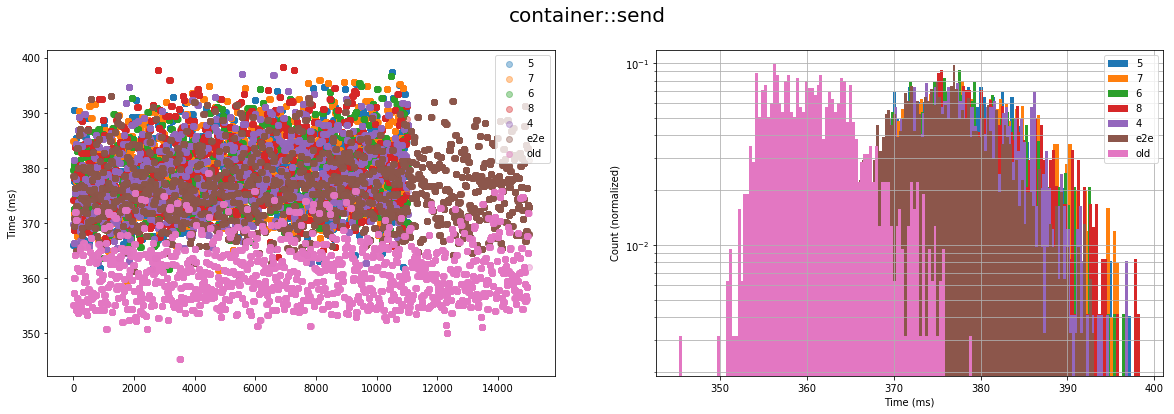

In [37]:
points_to_include = [
#     "driver::send",                  
#     "clipper::frontend_rpc_recv", 
#     "clipper::task_enqueued",
#     "clipper::task_dequeued",
#     "clipper::sent_rpc",
#     "container::recv",
    "container::send",
#     "clipper::rpc_recv",
#     "clipper::task_executor_recv",
#     "clipper::task_executor_msg_callback_found",
#     "clipper::task_executor_recv_end",
#     "clipper::zmq_frontend_response_callback",
#     "clipper::frontend_rpc_response_send",
#     "driver::recv"
]
for point in lineage_order:
    if point in points_to_include:
        fig, (ax_scatter, ax_hist) = plt.subplots(ncols=2, figsize=(20,6))
        for n, extracted_lineage in deltas.items():
            print(n)
            v = extracted_lineage[point]
            if len(v) > 0:
                ax_scatter.scatter(np.arange(len(v)), v, alpha = 0.4, label=str(n))
                ax_hist.hist(v, 100, label=str(n), normed=True, histtype='bar', cumulative=False, log=True)
        ax_scatter.set_ylabel("Time (ms)")
        ax_scatter.legend(loc=0)
        ax_hist.legend(loc=0)   
        xmax = ax_hist.get_xlim()[1]
        ax_hist.set_xlim(right=max(10, xmax))
        ax_hist.set_xlabel("Time (ms)")
        ax_hist.set_ylabel("Query ID")
        ax_hist.set_ylabel("Count (normalized)")
        ax_hist.grid(b=True, which="both")
        fig.suptitle(point, fontsize=20)
        plt.show()

CCCCCCCCCCCCCCCCCCC
CCCCCCCCCCCCCCCCCCC


# Model: inception

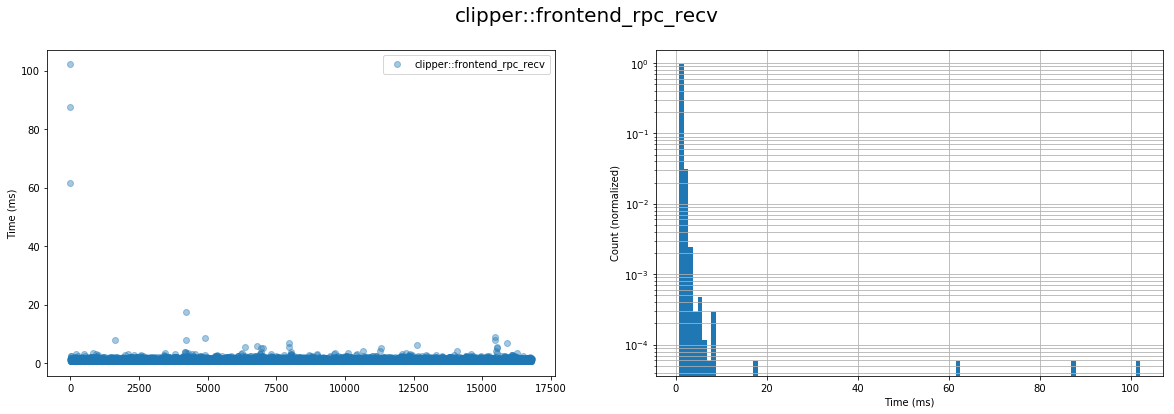

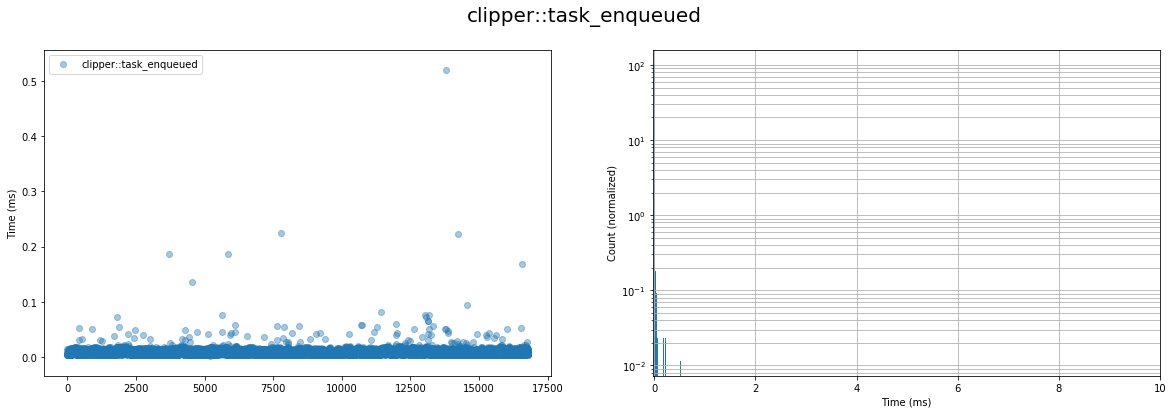

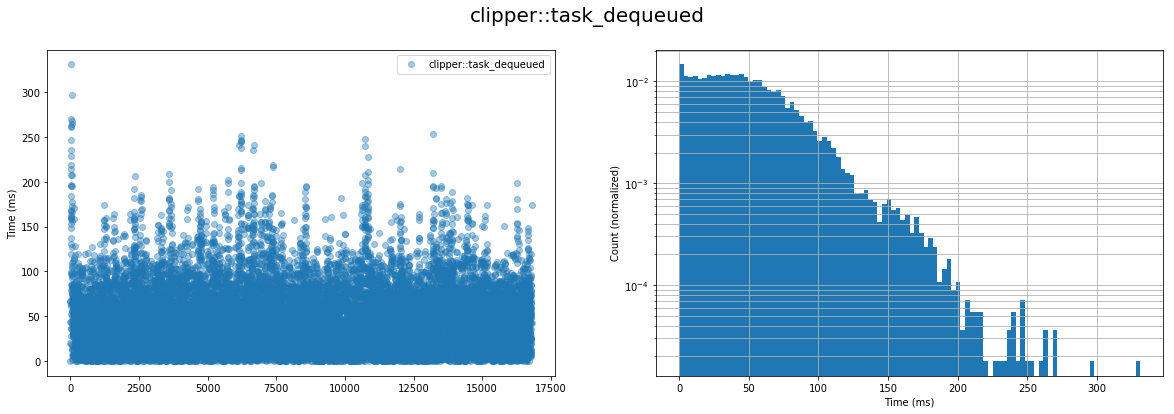

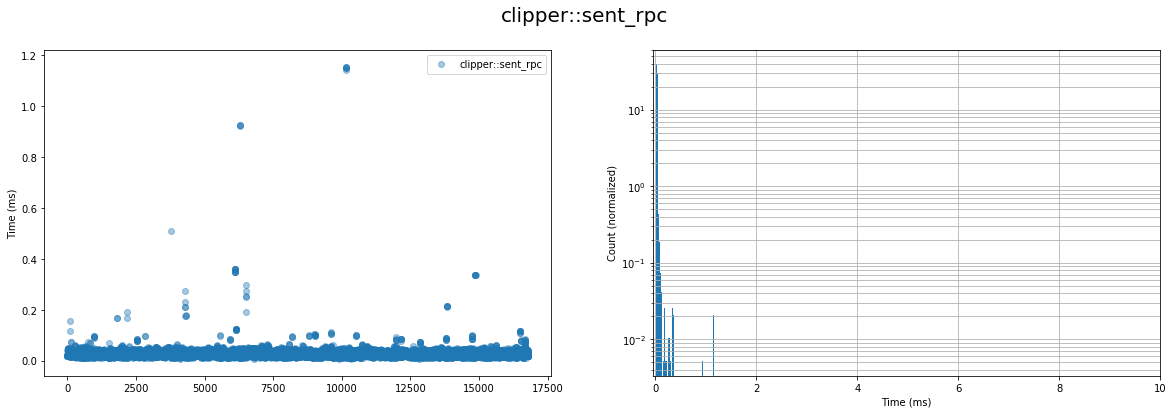

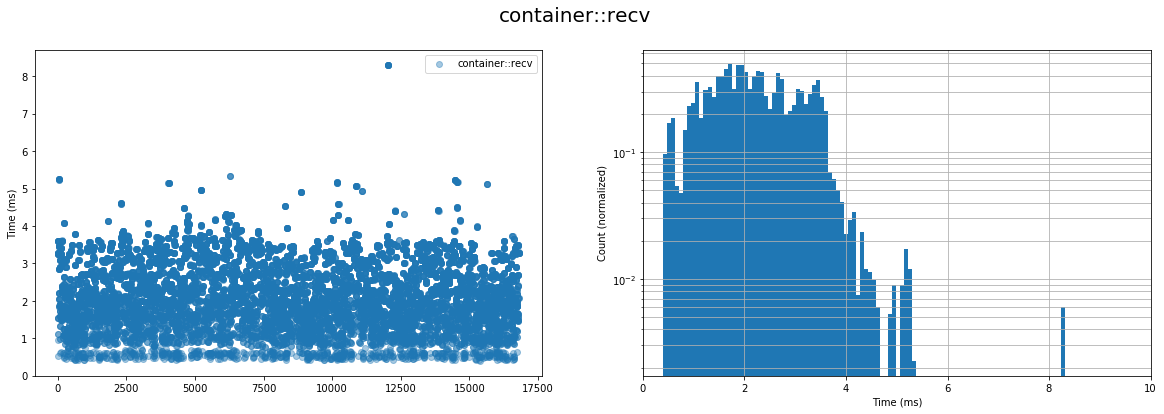

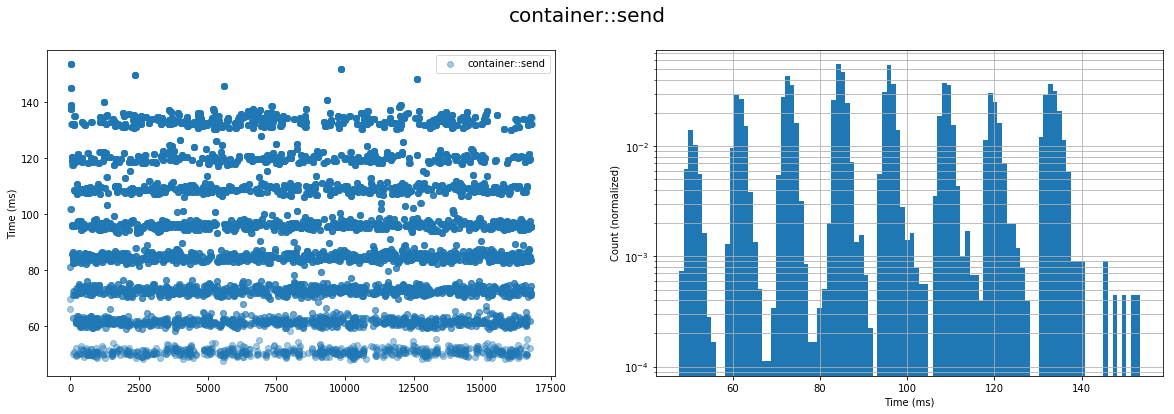

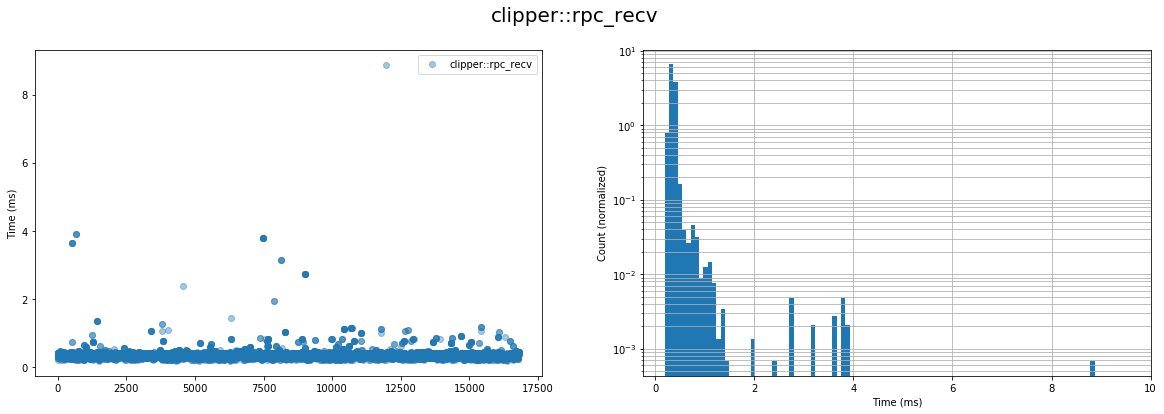

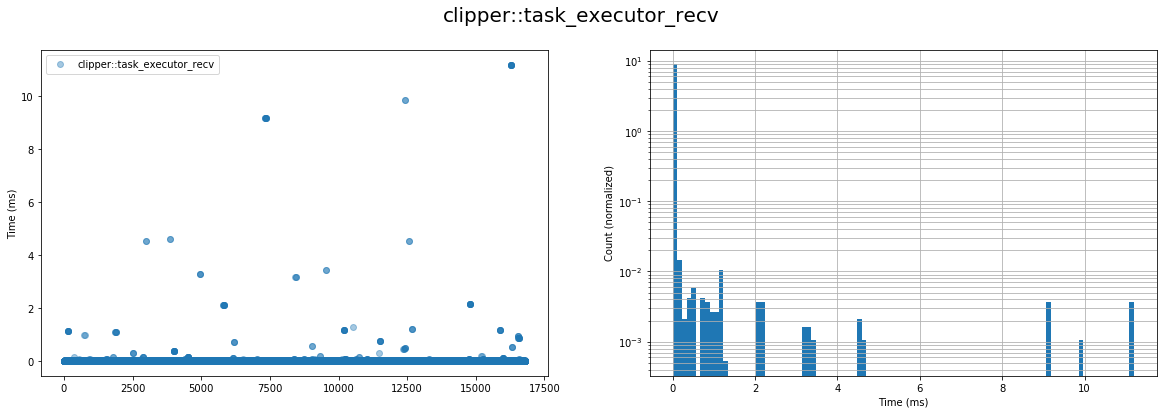

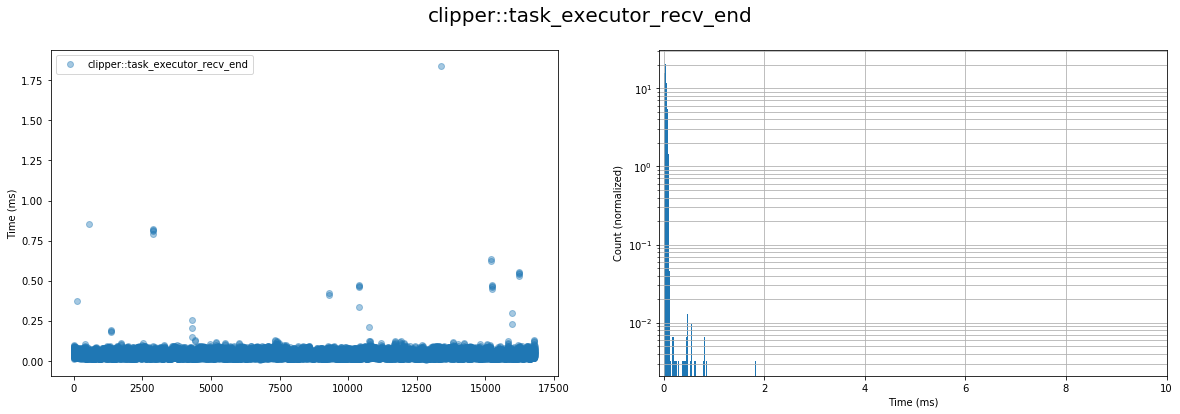

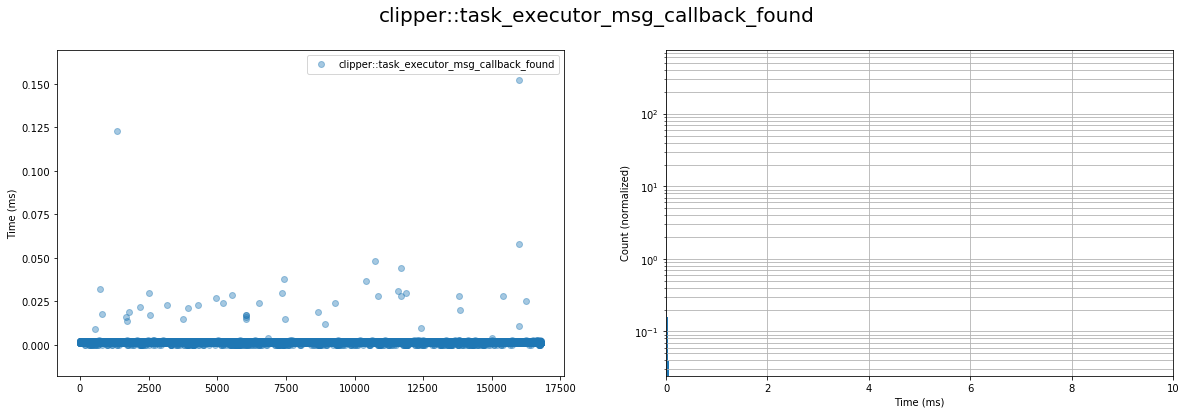

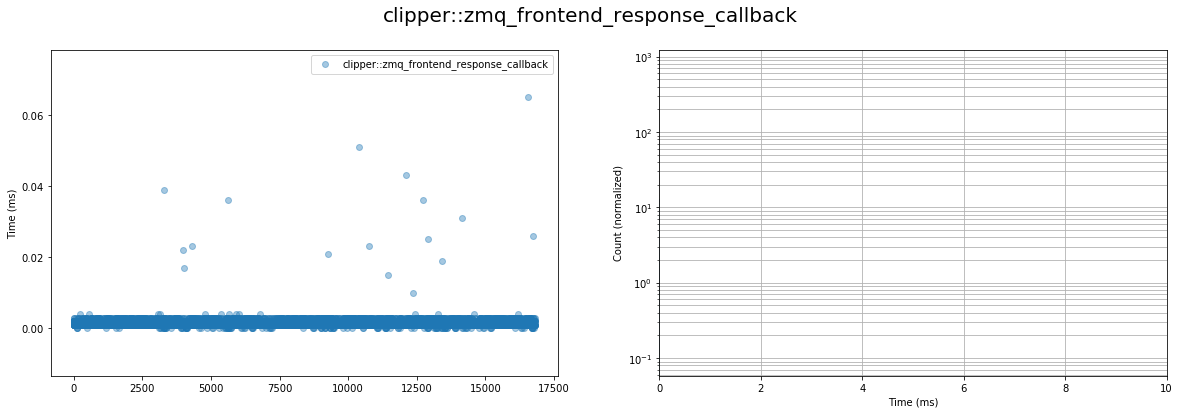

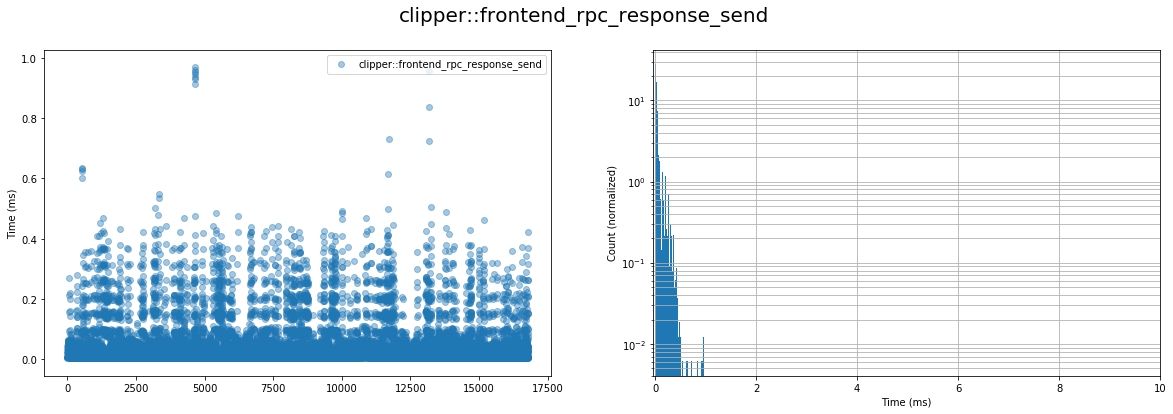

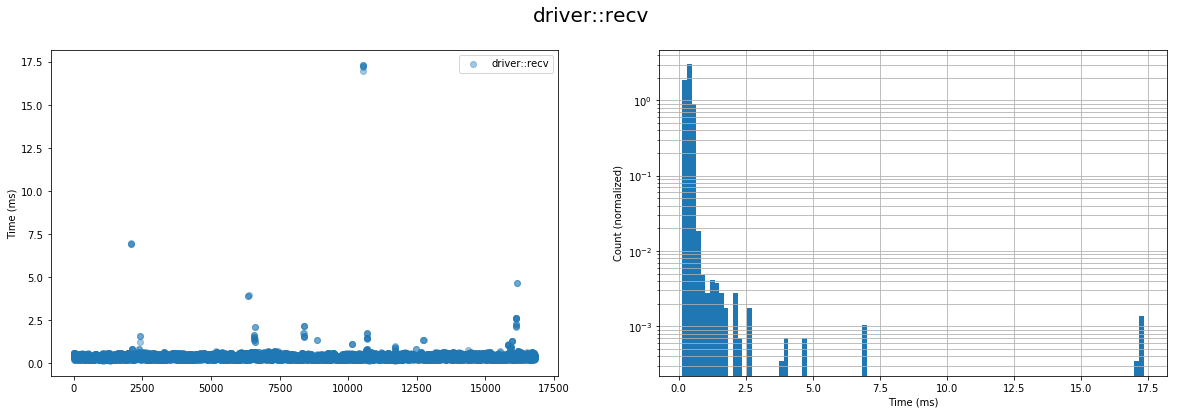

# Model: tf-kernel-svm

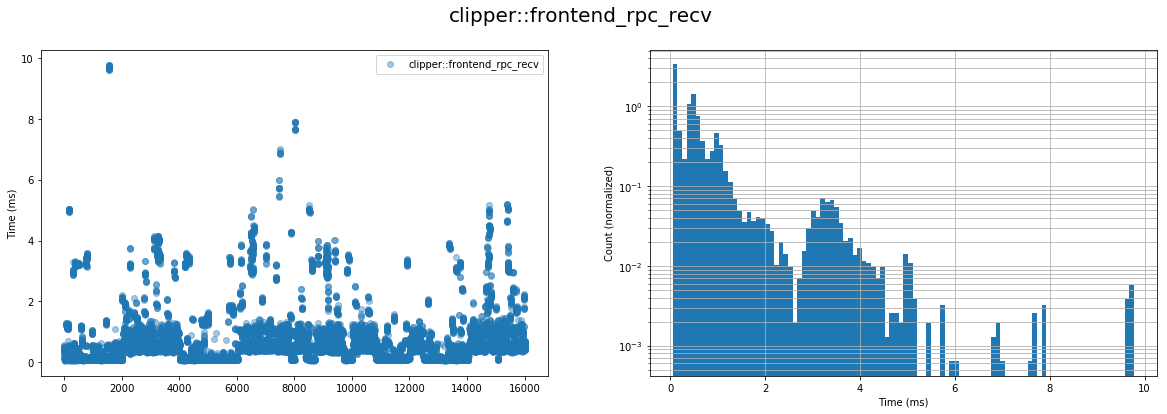

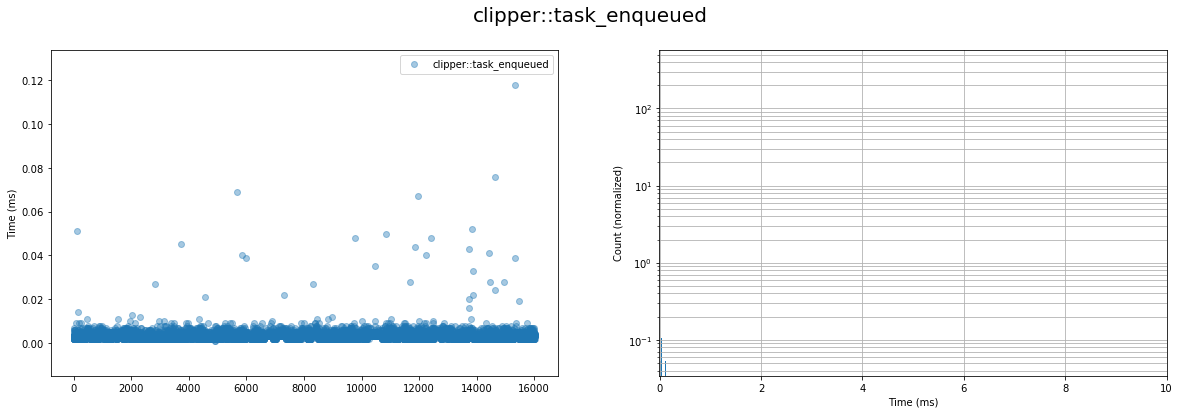

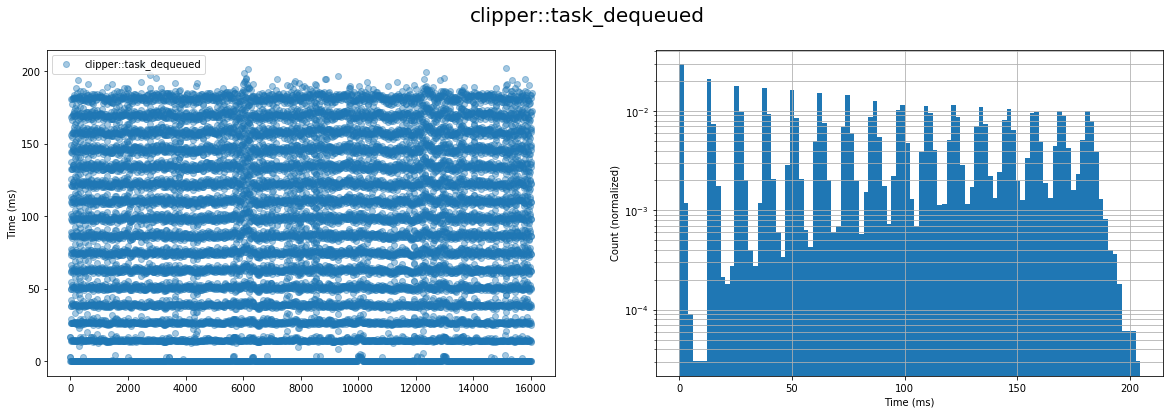

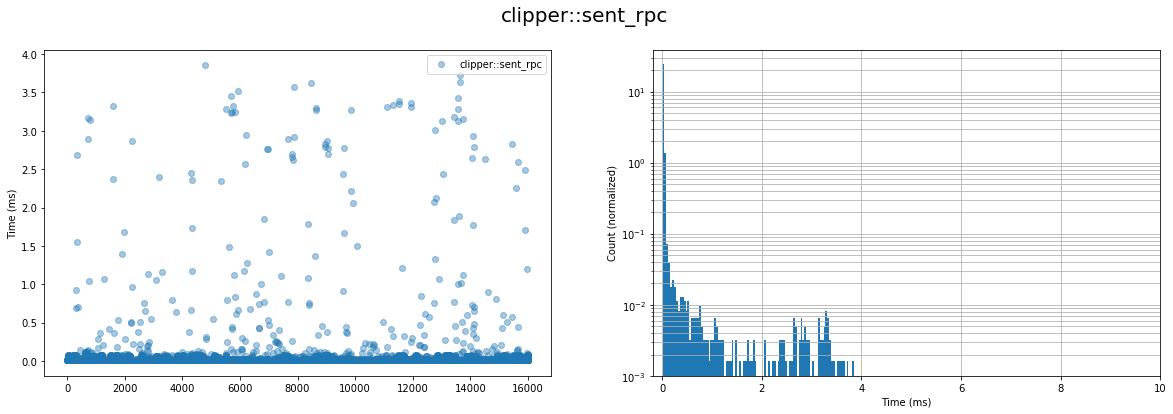

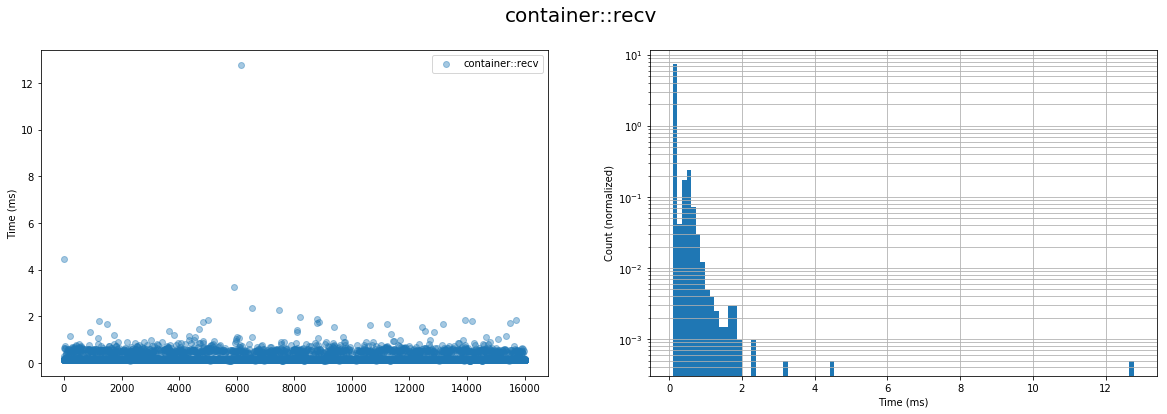

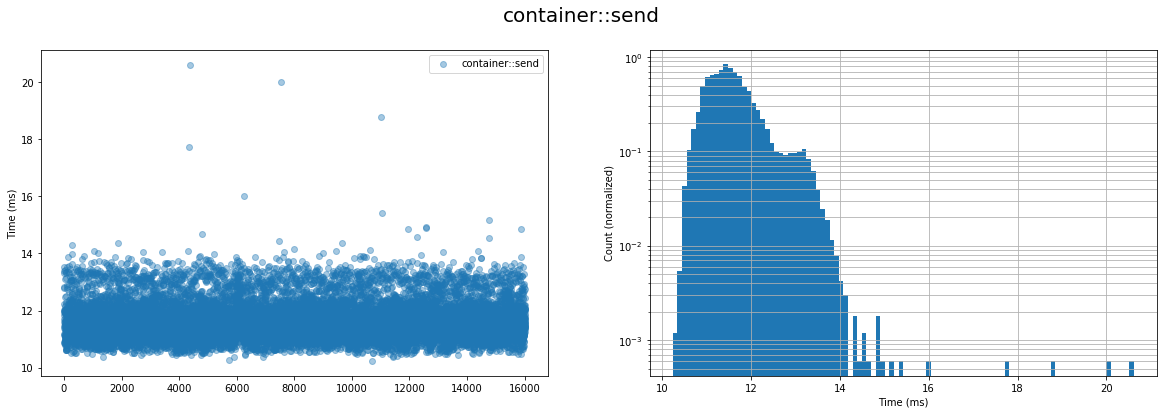

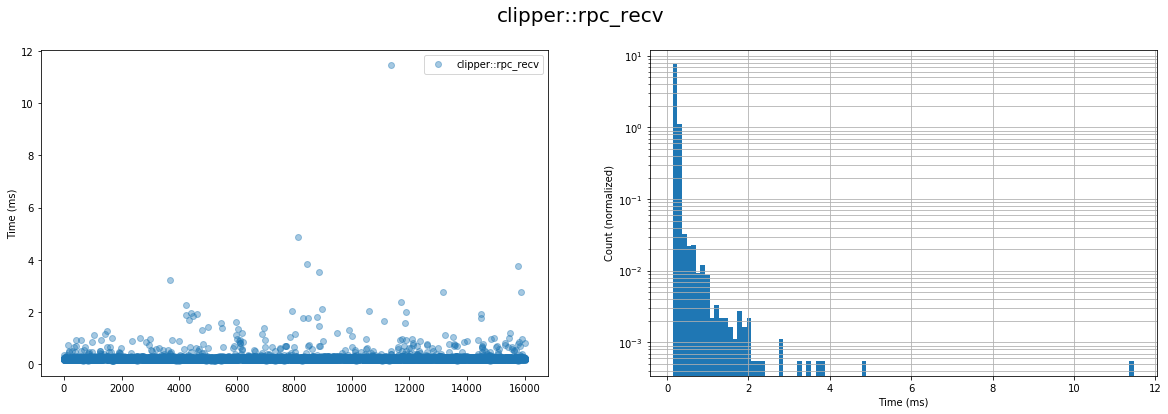

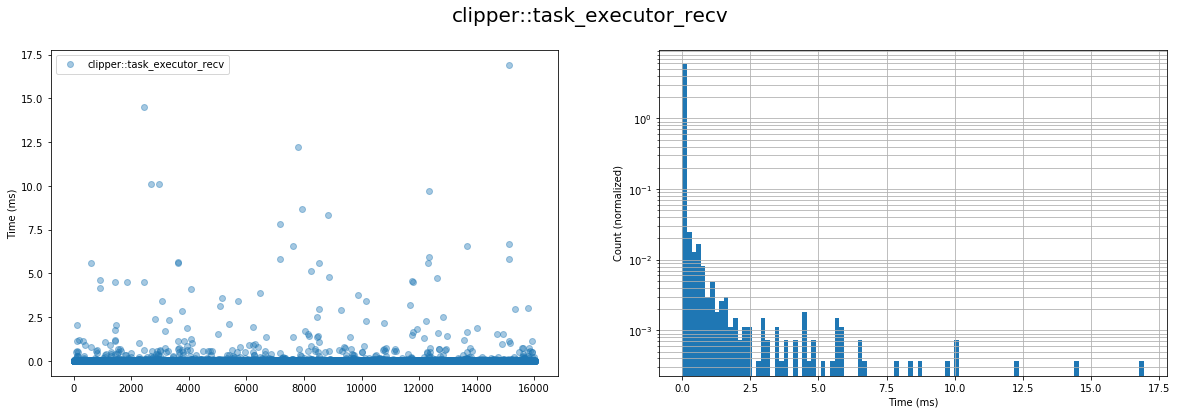

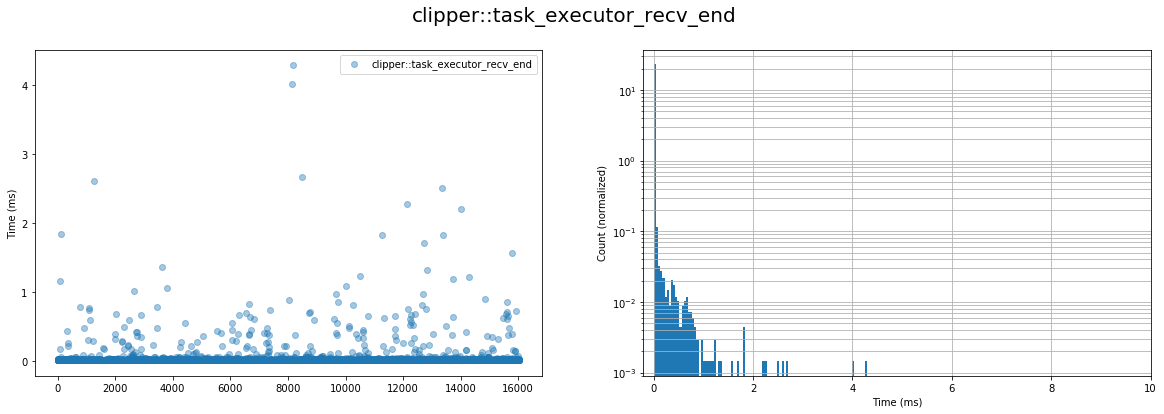

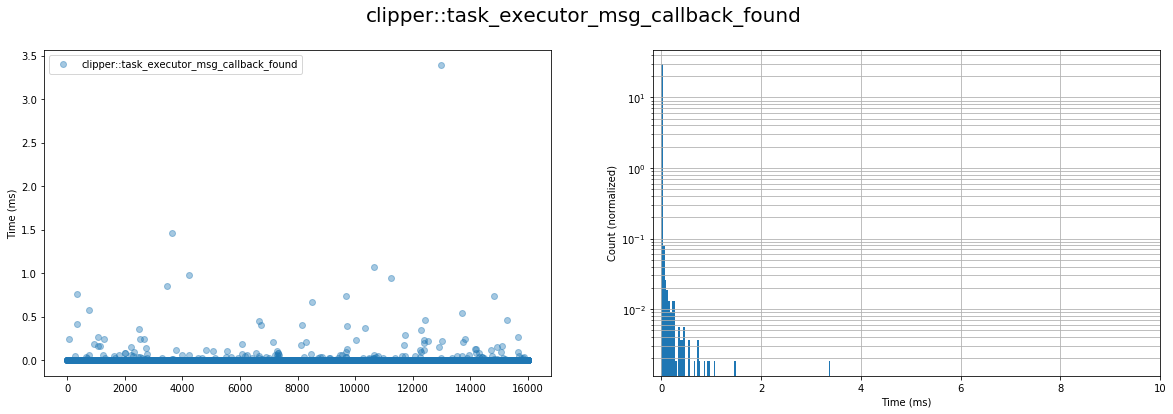

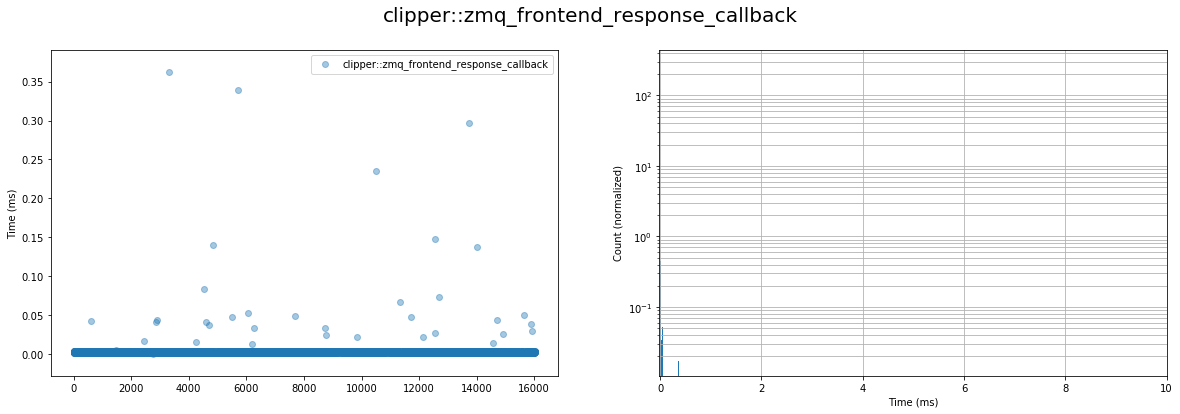

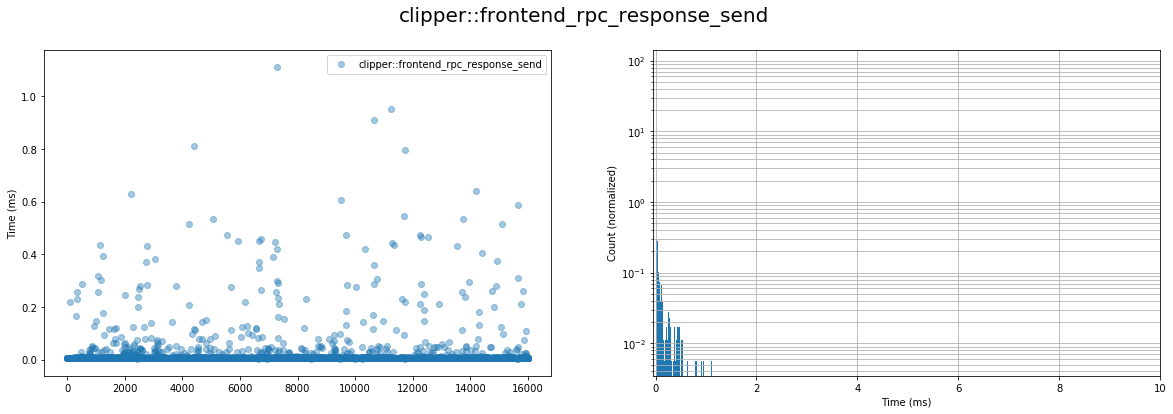

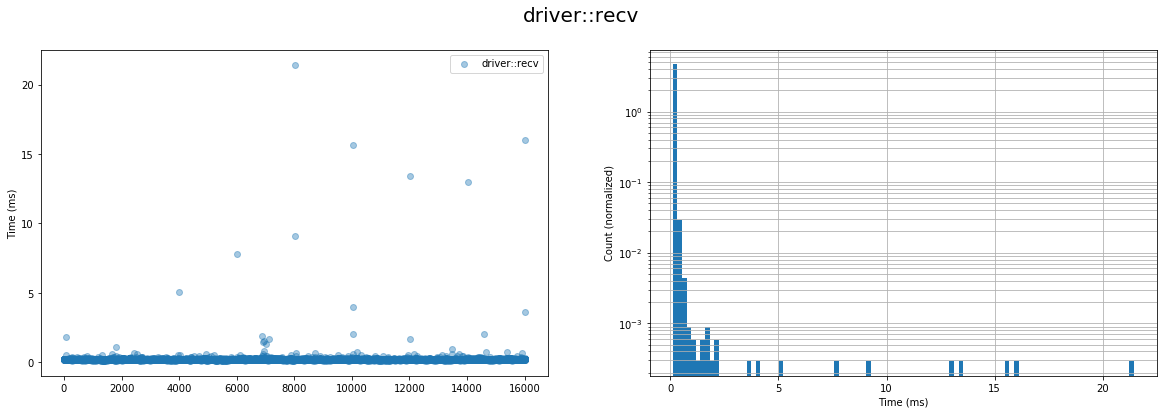

# Model: tf-resnet-feats

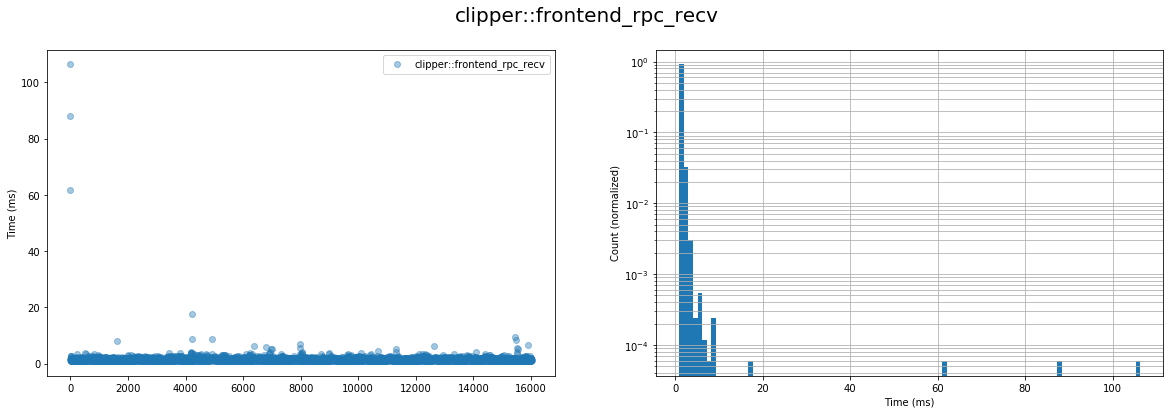

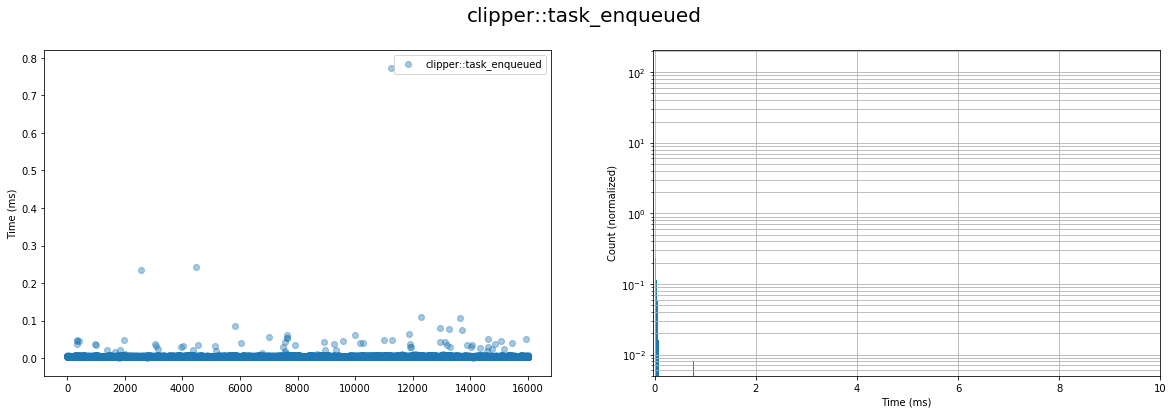

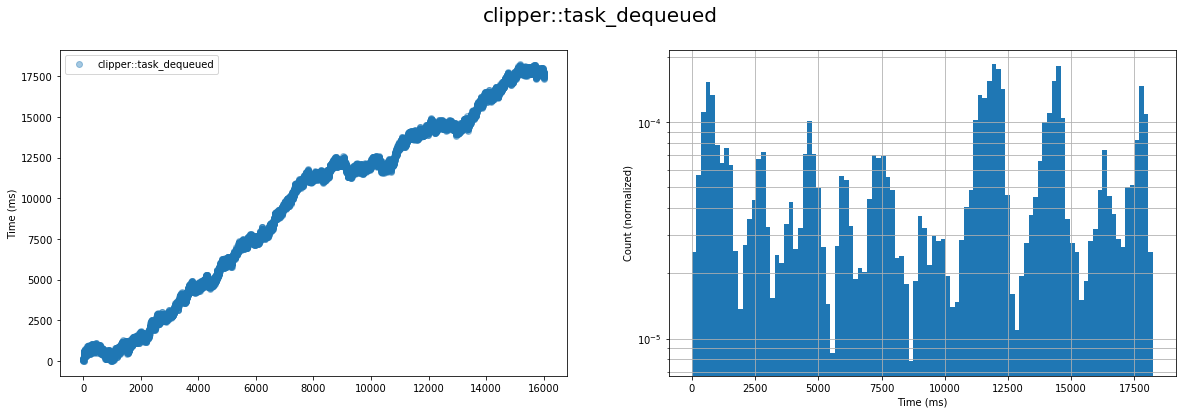

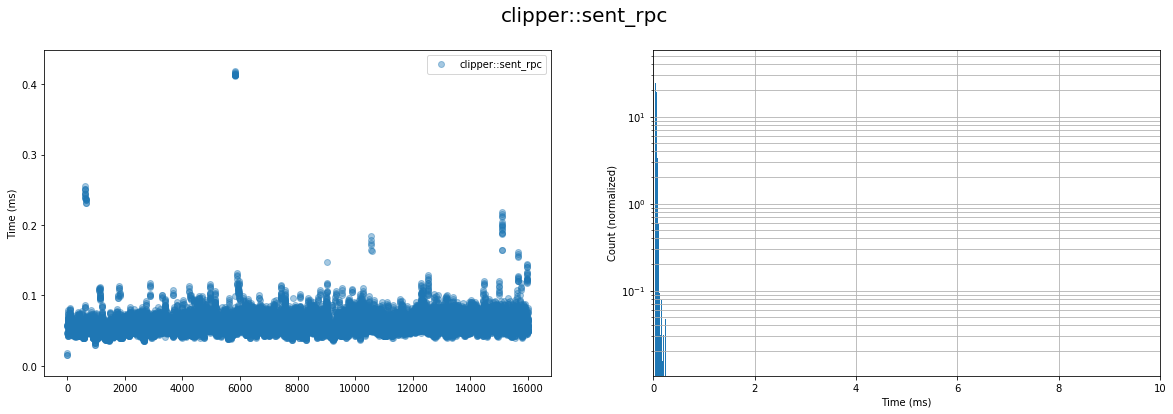

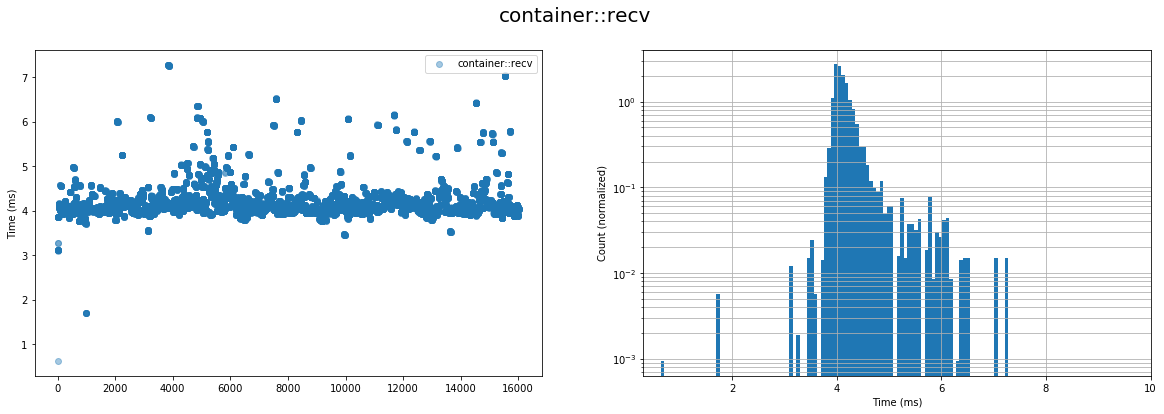

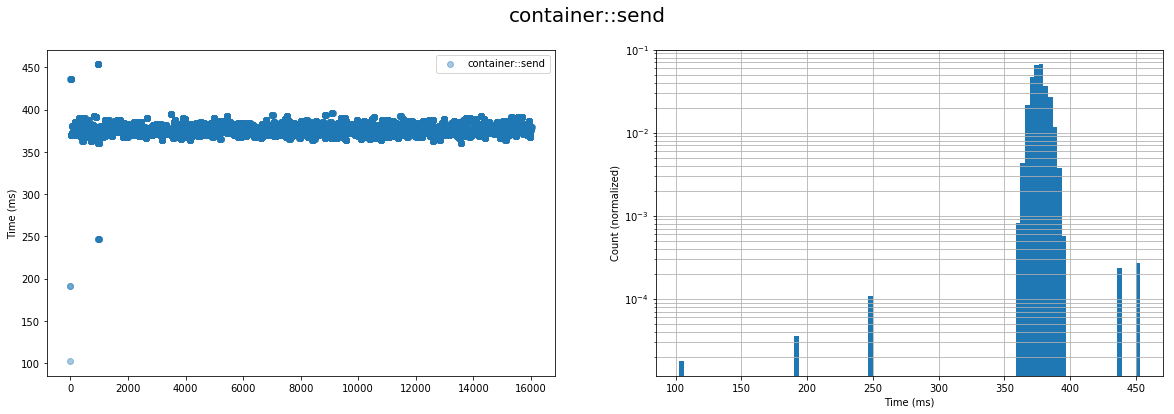

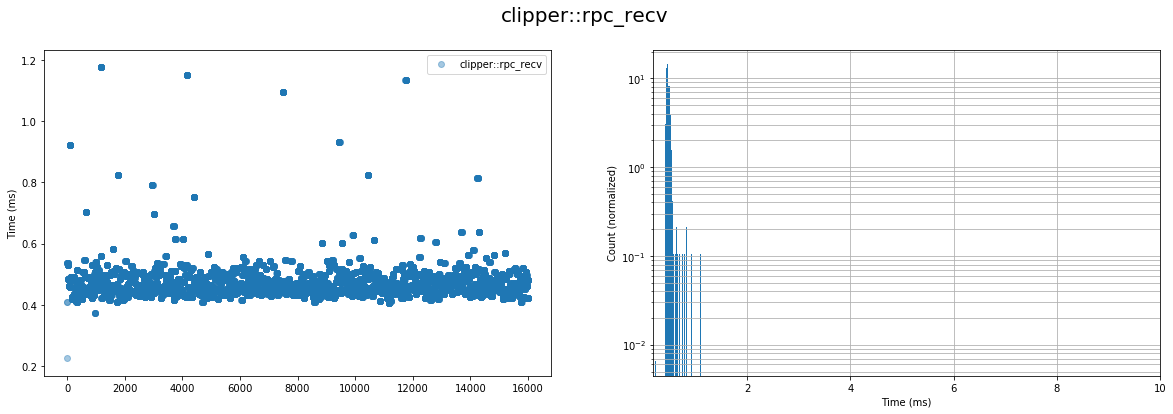

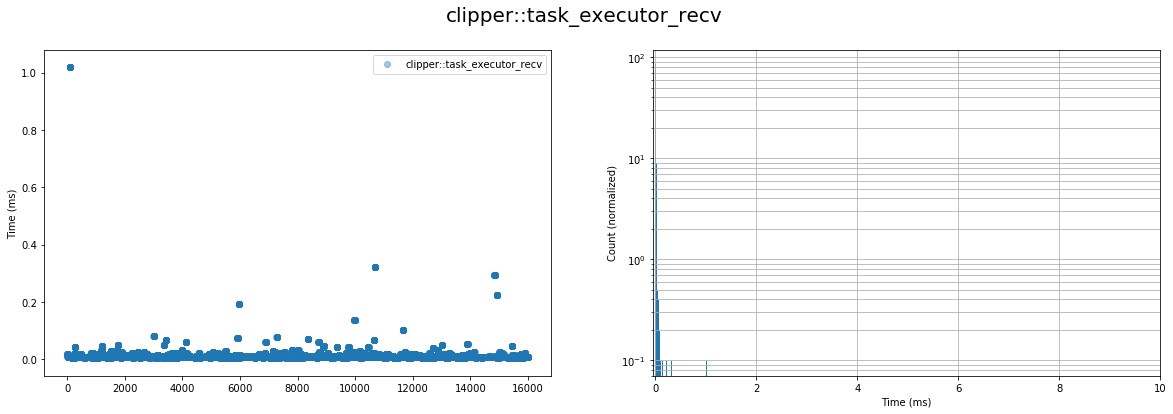

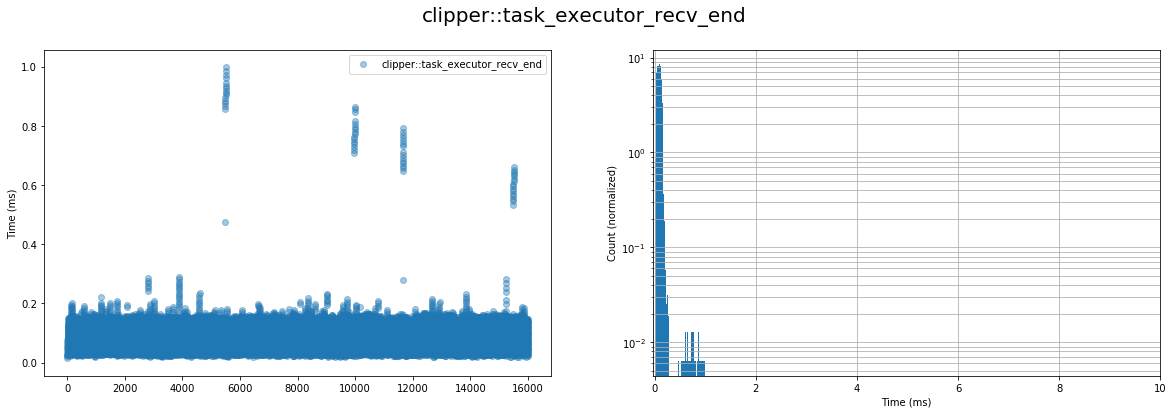

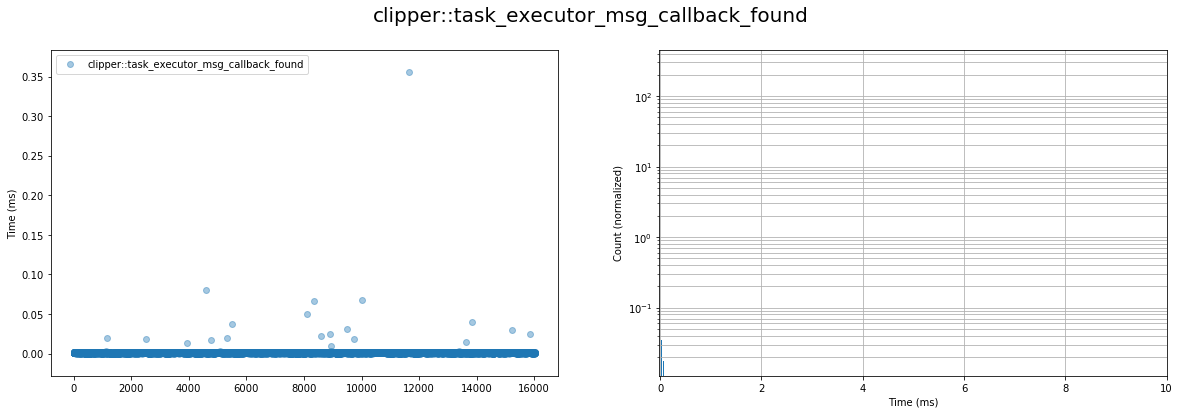

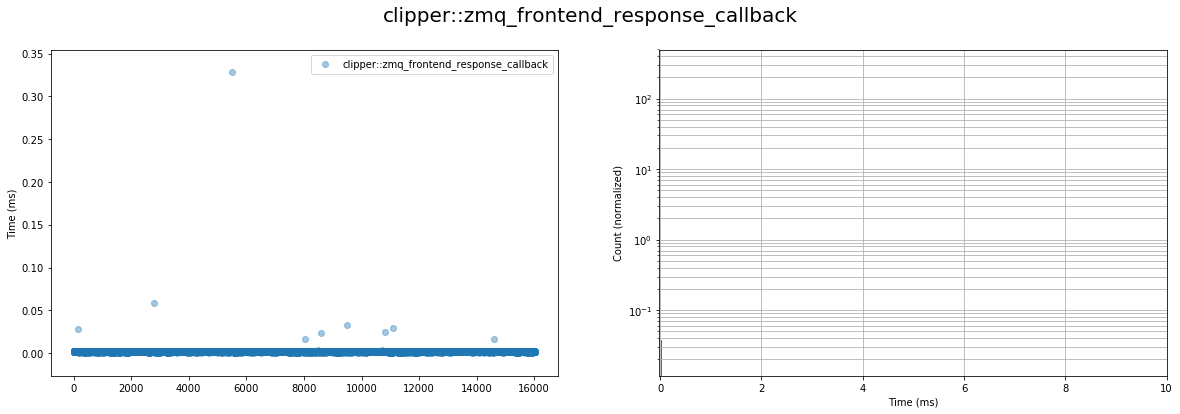

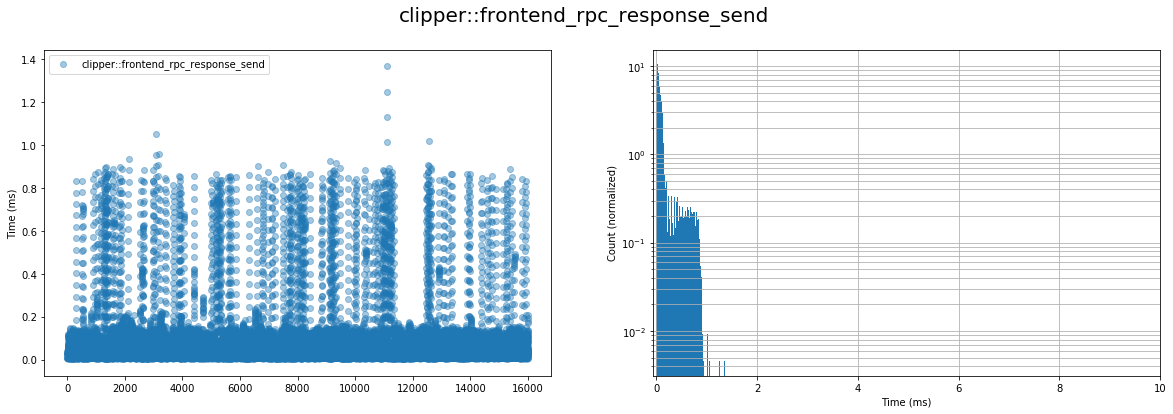

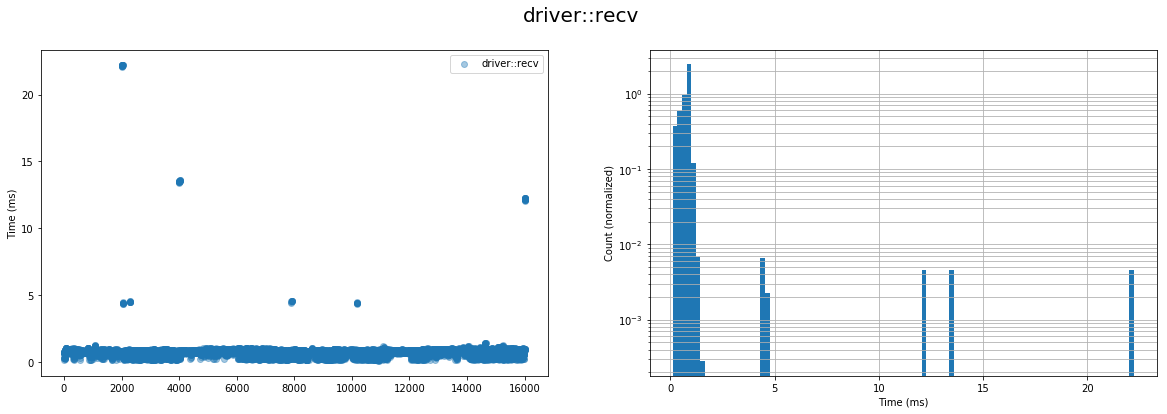

# Model: tf-log-reg

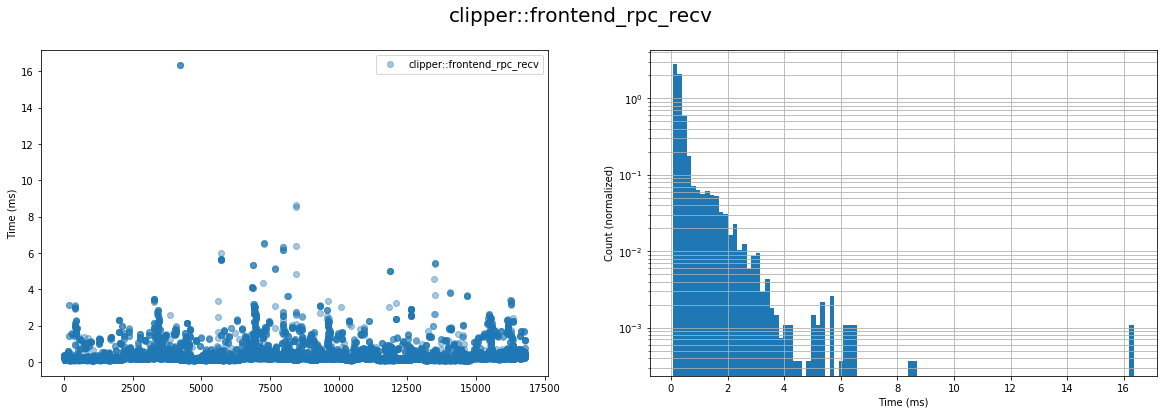

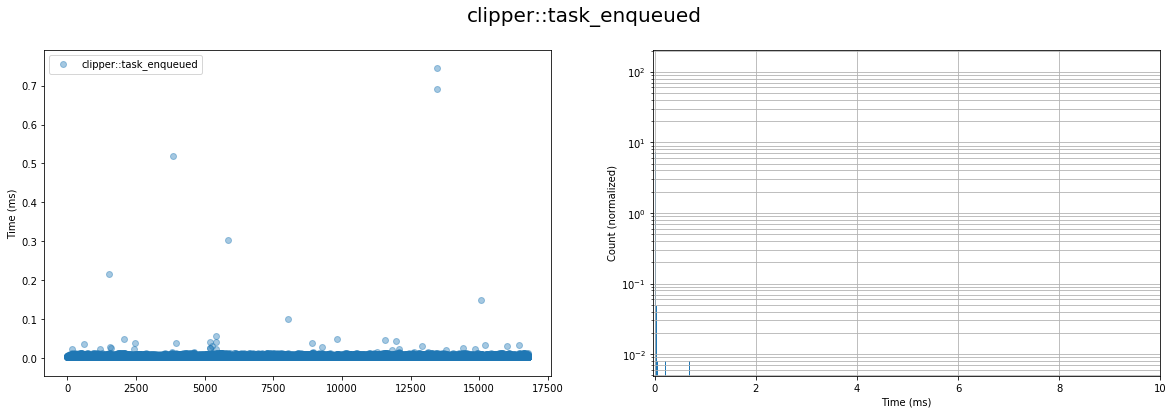

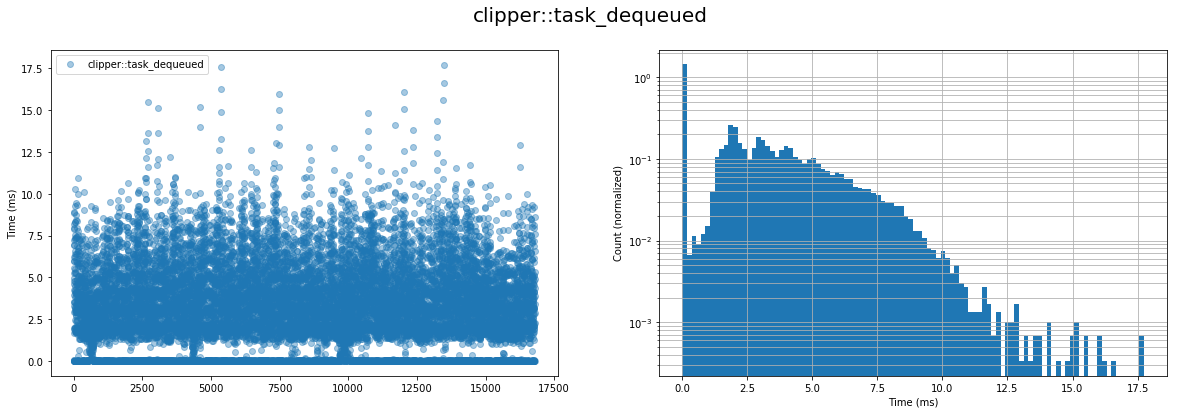

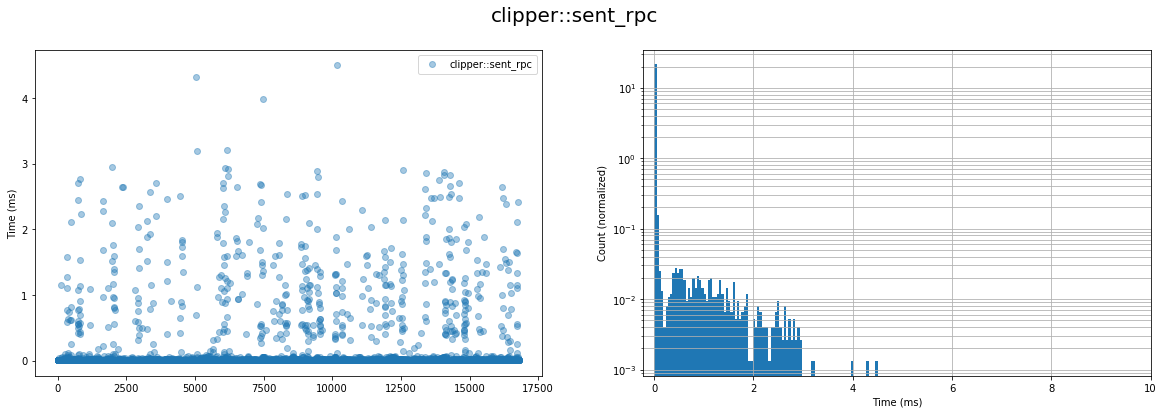

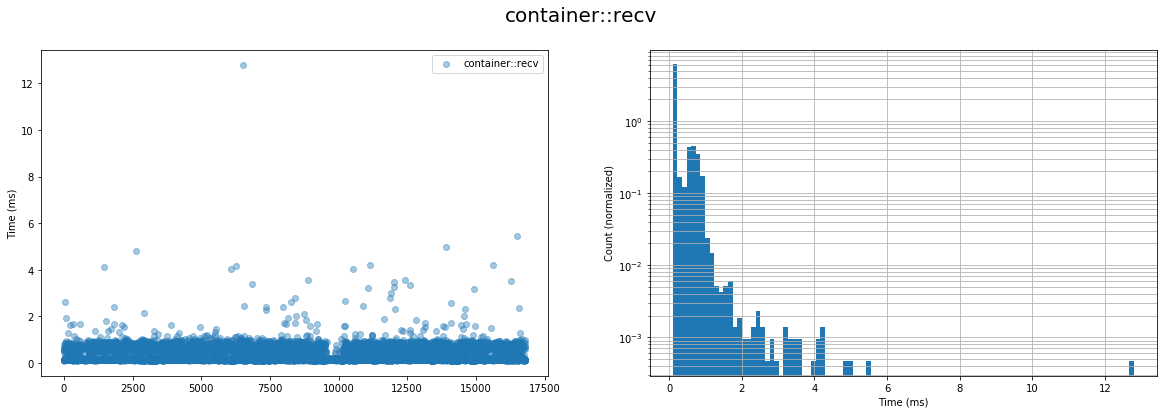

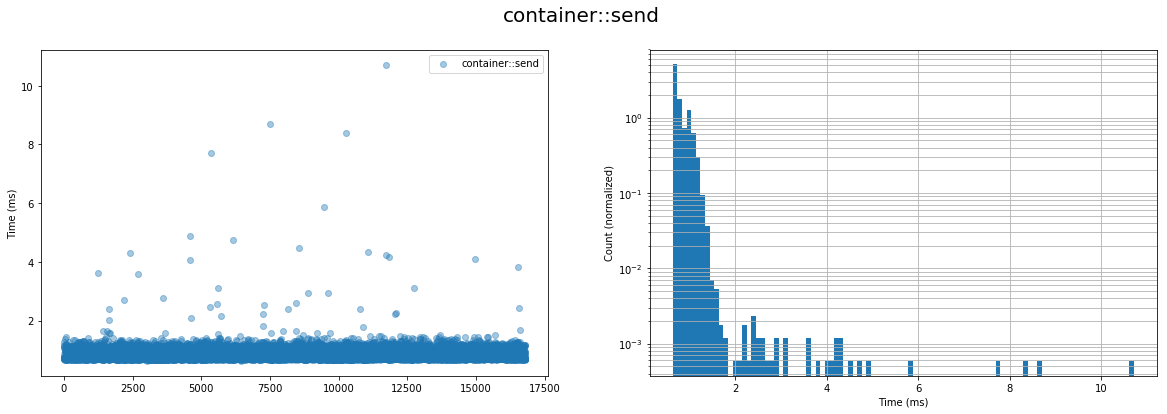

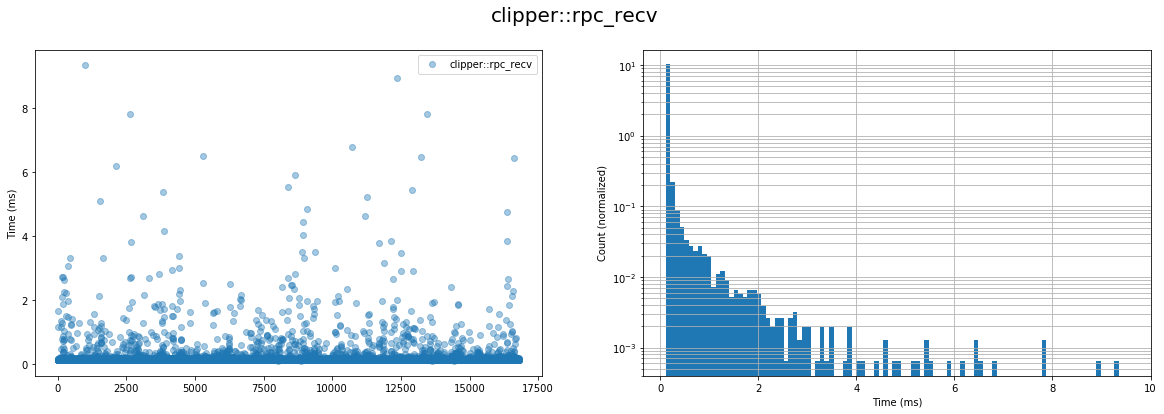

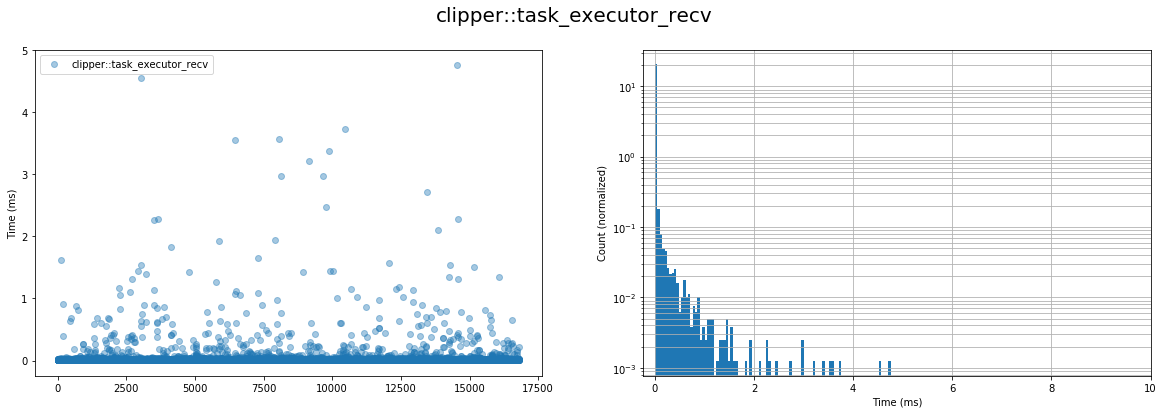

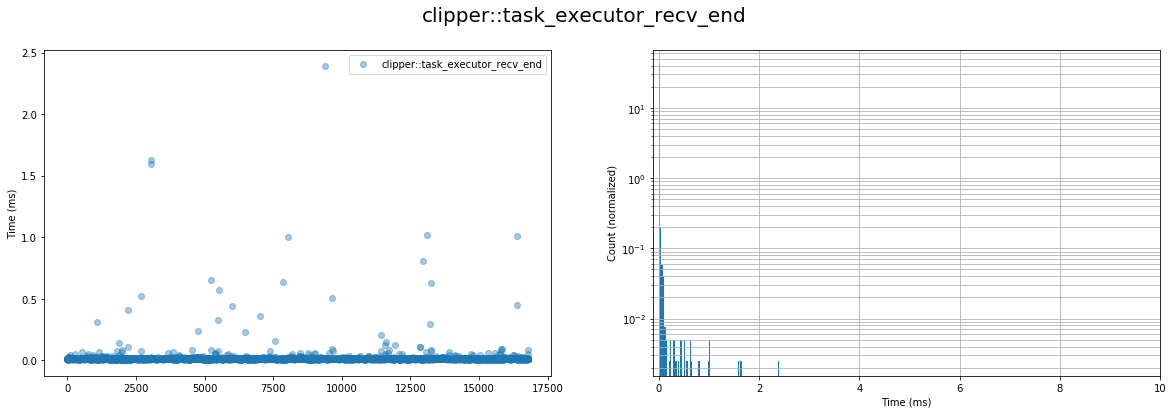

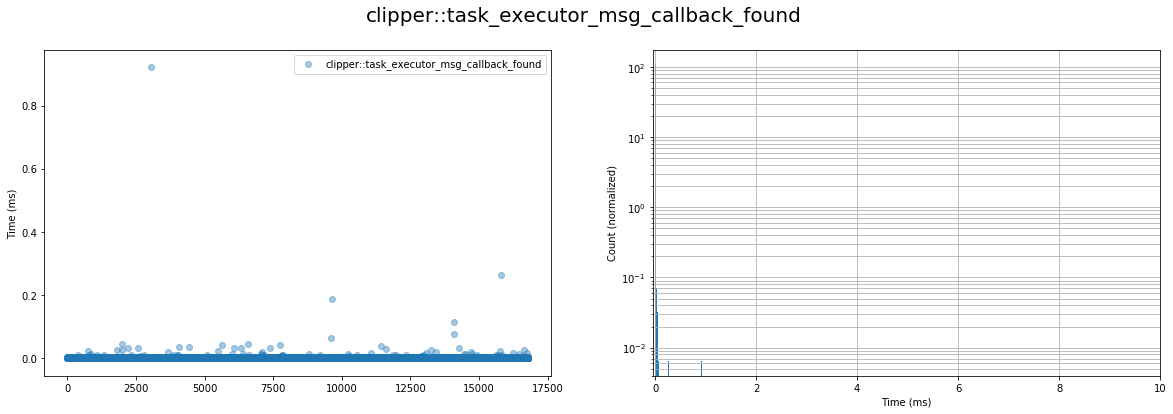

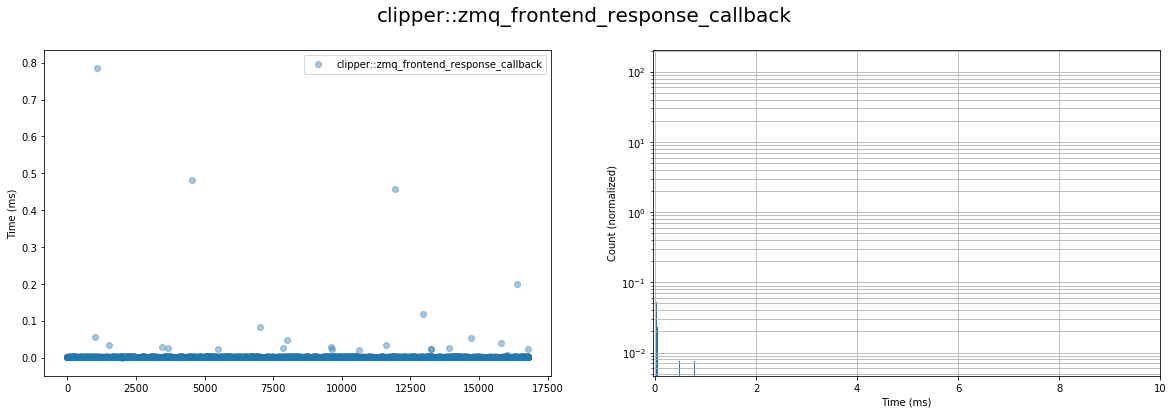

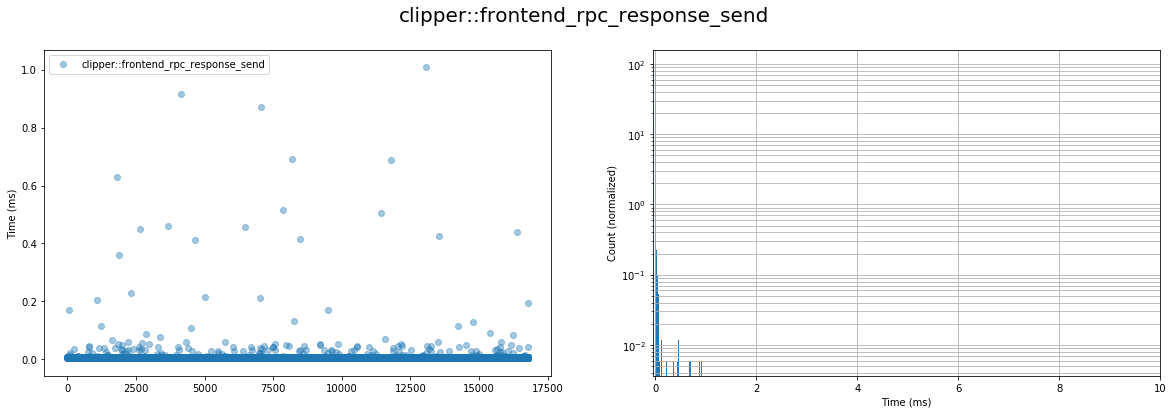

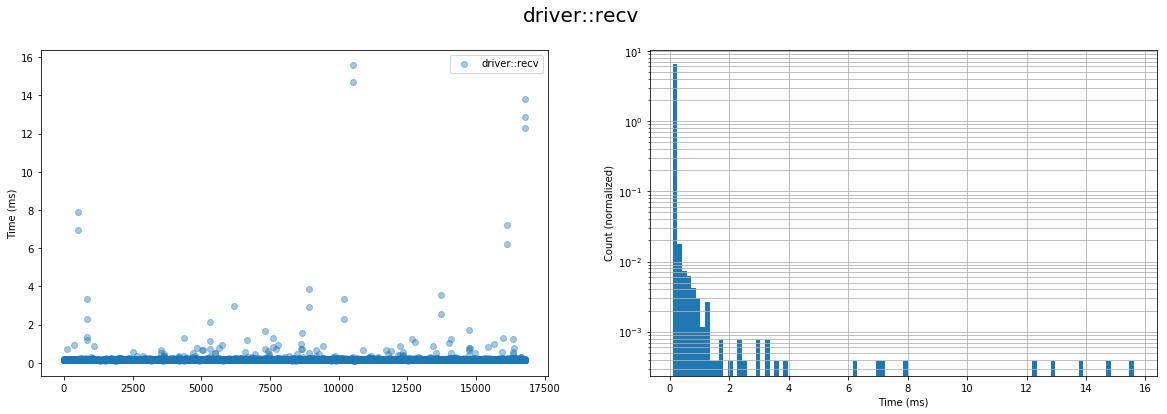

In [4]:
fpath = "../results_cpp_benchmarker/query_lineage_e2e/cpp-aws-p2-1-inception-1-resnet-1-ksvm-1-logreg-180322_194534.json"
analyze_lineage(fpath)